In [2]:
# cell 1
import re
import math
import pandas as pd
import numpy as np
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import configparser
import os
from datetime import datetime, timedelta
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Try to import optional sentiment analysis libraries
try:
    from textblob import TextBlob
    SENTIMENT_AVAILABLE = True
except:
    SENTIMENT_AVAILABLE = False
    print("Note: TextBlob not available for sentiment analysis")

In [3]:
# cell 2
# Load API key
config = configparser.ConfigParser()
config.read_file(open('YoutubeAPI.cfg'))
os.environ["Youtube_API_Access_KEY"] = config['Youtube API']['API_KEY']

# Initialize YouTube API
youtube = build('youtube', 'v3', developerKey=os.environ["Youtube_API_Access_KEY"])

In [ ]:
# CSV Cache Configuration
from pathlib import Path

CACHE_DIR = Path("CommunityCSV")
CACHE_DIR.mkdir(exist_ok=True)
GT_CACHE_PATH = CACHE_DIR / "gt_test_comments.csv"

def save_comments_to_cache(all_comments, channel_name):
    """Save comments to CSV for caching (temporary, will be replaced by consolidated CSV)"""
    df = pd.DataFrame(all_comments)
    cache_file = CACHE_DIR / f"gt_test_{channel_name.replace(' ', '_')}_comments.csv"
    df.to_csv(cache_file, index=False)
    print(f"✓ Saved temporary comment cache to {cache_file}")
    return cache_file

def load_comments_from_cache(channel_name):
    """Load comments from CSV cache"""
    cache_file = CACHE_DIR / f"gt_test_{channel_name.replace(' ', '_')}_comments.csv"
    
    if cache_file.exists():
        df = pd.read_csv(cache_file)
        print(f"✓ Loaded {len(df)} cached comments from {cache_file}")
        return df.to_dict('records')
    
    # Try generic cache
    if GT_CACHE_PATH.exists():
        df = pd.read_csv(GT_CACHE_PATH)
        print(f"✓ Loaded {len(df)} cached comments from {GT_CACHE_PATH}")
        return df.to_dict('records')
    
    raise FileNotFoundError(f"No cached comments found in {CACHE_DIR}/")

def cache_exists(channel_name):
    """Check if cache exists for this channel"""
    cache_file = CACHE_DIR / f"gt_test_{channel_name.replace(' ', '_')}_comments.csv"
    return cache_file.exists() or GT_CACHE_PATH.exists()

In [5]:
# cell 3
def resolve_channel_id(channel_url):
    """Resolve any YouTube URL to channel ID"""
    patterns = [
        (r"youtube\.com/channel/(UC[\w-]+)", "channel"),
        (r"youtube\.com/user/([\w-]+)", "user"),
        (r"youtube\.com/@([\w\.\-]+)", "handle")
    ]

    for pattern, kind in patterns:
        match = re.search(pattern, channel_url)
        if match:
            if kind == "channel":
                return match.group(1)
            elif kind == "user":
                response = youtube.channels().list(
                    part="id",
                    forUsername=match.group(1)
                ).execute()
                return response['items'][0]['id'] if response.get('items') else None
            elif kind == "handle":
                response = youtube.search().list(
                    part="snippet",
                    q=match.group(1),
                    type="channel",
                    maxResults=1
                ).execute()
                return response['items'][0]['snippet']['channelId'] if response.get('items') else None

    raise ValueError("Could not resolve channel URL")

def get_channel_url():
    """Get channel URL from user input"""
    print("=" * 60)
    print("YouTube Channel Influencer Analysis")
    print("=" * 60)
    print("\nSupported URL formats:")
    print("• https://www.youtube.com/channel/UCxxxx")
    print("• https://www.youtube.com/@handle")
    print("• https://www.youtube.com/user/username")
    print("\nEnter 'exit' to quit")
    print("-" * 60)

    while True:
        url = input("\nEnter YouTube Channel URL: ").strip()

        if url.lower() == 'exit':
            return None

        if not url.startswith(('http://', 'https://')):
            print("Please enter a valid URL starting with http:// or https://")
            continue

        return url

In [6]:
# cell 4
def get_channel_metadata(channel_id):
    """Get comprehensive channel information"""
    try:
        response = youtube.channels().list(
            part="snippet,statistics,brandingSettings,topicDetails",
            id=channel_id
        ).execute()

        if not response.get('items'):
            return None

        item = response['items'][0]

        metadata = {
            'title': item['snippet'].get('title', 'Unknown'),
            'description': item['snippet'].get('description', ''),
            'published_at': item['snippet'].get('publishedAt', ''),
            'subscriber_count': int(item['statistics'].get('subscriberCount', 0)),
            'video_count': int(item['statistics'].get('videoCount', 0)),
            'view_count': int(item['statistics'].get('viewCount', 0)),
            'country': item.get('brandingSettings', {}).get('channel', {}).get('country', ''),
            'keywords': item.get('brandingSettings', {}).get('channel', {}).get('keywords', ''),
            'topics': item.get('topicDetails', {}).get('topicCategories', []),
            'profile_image': item['snippet'].get('thumbnails', {}).get('high', {}).get('url', '')
        }

        # Calculate engagement rate (approximate)
        if metadata['subscriber_count'] > 0:
            metadata['engagement_rate'] = (metadata['view_count'] / metadata['subscriber_count']) / metadata['video_count'] * 100
        else:
            metadata['engagement_rate'] = 0

        return metadata

    except Exception as e:
        print(f"Error fetching channel metadata: {e}")
        return None


In [7]:
# cell 5
def get_channel_videos(channel_id, max_videos=50, timeframe_days=180):
    """Get recent videos with metadata"""
    videos = []
    next_page_token = None

    # Calculate the publishedAfter date string in ISO 8601 format
    published_after = (datetime.utcnow() - timedelta(days=timeframe_days)).isoformat() + "Z"

    try:
        while len(videos) < max_videos:
            request = youtube.search().list(
                part="id,snippet",
                channelId=channel_id,
                type="video",
                order="date",
                publishedAfter=published_after,  # ADD THIS LINE
                maxResults=min(50, max_videos - len(videos)),
                pageToken=next_page_token
            )
            response = request.execute()

            for item in response.get('items', []):
                video_id = item['id']['videoId']

                # Get detailed video statistics (same as before)
                video_response = youtube.videos().list(
                    part="statistics,snippet,contentDetails",
                    id=video_id
                ).execute()

                if video_response.get('items'):
                    video_data = video_response['items'][0]

                    video_info = {
                        'video_id': video_id,
                        'title': video_data['snippet']['title'],
                        'published_at': video_data['snippet']['publishedAt'],
                        'views': int(video_data['statistics'].get('viewCount', 0)),
                        'likes': int(video_data['statistics'].get('likeCount', 0)),
                        'comments': int(video_data['statistics'].get('commentCount', 0)),
                        'duration': video_data['contentDetails'].get('duration', 'PT0S'),
                        'description': video_data['snippet'].get('description', '')
                    }

                    # Calculate engagement metrics (same as before)
                    if video_info['views'] > 0:
                        video_info['like_rate'] = (video_info['likes'] / video_info['views']) * 100
                        video_info['comment_rate'] = (video_info['comments'] / video_info['views']) * 100
                    else:
                        video_info['like_rate'] = 0
                        video_info['comment_rate'] = 0

                    videos.append(video_info)

            next_page_token = response.get('nextPageToken')
            if not next_page_token:
                break

    except HttpError as e:
        print(f"API Error: {e}")
    except Exception as e:
        print(f"Error: {e}")

    return videos

In [8]:
# cell 6
def analyze_comments(video_id, channel_owner_id):
    """Collect and analyze comments with multiple metrics"""
    all_comments = []
    reply_edges = []

    try:
        # Get all comment threads
        next_page_token = None
        while True:
            response = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id,
                maxResults=100,
                pageToken=next_page_token,
                order="relevance"
            ).execute()

            for thread in response.get('items', []):
                # Top-level comment
                top_comment = thread['snippet']['topLevelComment']
                thread_snippet = thread['snippet']  # This contains totalReplyCount!

                # Get the total reply count from THREAD level
                thread_total_reply_count = thread_snippet.get('totalReplyCount', 0)

                top_data = extract_comment_metrics(top_comment, channel_owner_id, is_reply=False)
                # IMPORTANT: Add thread-level reply count to top comment
                top_data['total_reply_count'] = thread_total_reply_count
                all_comments.append(top_data)

                # Get replies
                if 'replies' in thread:
                    for reply in thread['replies']['comments']:
                        reply_data = extract_comment_metrics(reply, channel_owner_id, is_reply=True)
                        all_comments.append(reply_data)

                        # Add reply edge (replier -> original author)
                        reply_edges.append({
                            'from': reply_data['author_id'],
                            'to': top_data['author_id'],
                            'video_id': video_id,
                            'timestamp': reply_data['published_at']
                        })

            next_page_token = response.get('nextPageToken')
            if not next_page_token:
                break

    except Exception as e:
        print(f"Error analyzing comments for video {video_id}: {e}")

    return all_comments, reply_edges

def extract_comment_metrics(comment, channel_owner_id, is_reply=False):
    """Extract comprehensive metrics from a single comment"""
    snippet = comment['snippet']
    text = snippet.get('textDisplay', '')

    # Basic metrics
    metrics = {
        'comment_id': comment['id'],
        'author_id': snippet.get('authorChannelId', {}).get('value', 'unknown'),
        'author_name': snippet.get('authorDisplayName', 'Unknown'),
        'text': text,
        'published_at': snippet['publishedAt'],
        'updated_at': snippet.get('updatedAt', snippet['publishedAt']),
        'like_count': snippet.get('likeCount', 0),
        'is_reply': is_reply,
        'is_channel_owner': snippet.get('authorChannelId', {}).get('value') == channel_owner_id,
        'is_pinned': snippet.get('isPublic', False),
        'total_reply_count': 0,  # Default to 0, will be updated for top comments
        'parent_id': snippet.get('parentId', None) if is_reply else None
    }

    # Text analysis metrics
    metrics.update(analyze_comment_text(text))

    # Time analysis
    published_time = datetime.fromisoformat(metrics['published_at'].replace('Z', '+00:00'))
    metrics['hour_of_day'] = published_time.hour
    metrics['day_of_week'] = published_time.strftime('%A')

    return metrics

def analyze_comment_text(text):
    """Analyze comment text for various metrics"""
    analysis = {
        'text_length': len(text),
        'word_count': len(text.split()),
        'has_questions': int('?' in text),
        'has_exclamations': int('!' in text),
        'has_links': int('http://' in text.lower() or 'https://' in text.lower()),
        'has_mentions': int('@' in text),
        'has_hashtags': int('#' in text),
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / len(text) if text else 0
    }

    # Sentiment analysis if available
    if SENTIMENT_AVAILABLE:
        try:
            blob = TextBlob(text)
            analysis['sentiment_polarity'] = blob.sentiment.polarity
            analysis['sentiment_subjectivity'] = blob.sentiment.subjectivity
        except:
            analysis['sentiment_polarity'] = 0
            analysis['sentiment_subjectivity'] = 0
    else:
        analysis['sentiment_polarity'] = 0
        analysis['sentiment_subjectivity'] = 0

    # Emoji detection
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    analysis['has_emojis'] = int(bool(emoji_pattern.search(text)))

    return analysis

In [9]:
# cell 7 - REWRITTEN with 0-10 scoring
def calculate_influencer_scores(all_comments, reply_edges, videos_data):
    """Calculate comprehensive influencer scores normalized to 0-10 scale"""
    user_metrics = defaultdict(lambda: {
        'total_comments': 0,
        'total_likes': 0,
        'total_replies_received': 0,
        'reply_count': 0,
        'avg_sentiment': 0,
        'unique_videos': set(),
        'comment_lengths': [],
        'engagement_times': [],
        'thread_starts': 0,
        'channel_owner_replies_to': 0,
        'indegree': 0,
        'outdegree': 0,
        'response_times': [],
        'author_name': ''
    })

    # Process all comments (keep this section exactly the same)
    for comment in all_comments:
        author_id = comment['author_id']
        metrics = user_metrics[author_id]

        metrics['author_name'] = comment['author_name']
        metrics['total_comments'] += 1
        metrics['total_likes'] += comment['like_count']
        metrics['total_replies_received'] += comment['total_reply_count']
        metrics['comment_lengths'].append(comment['text_length'])
        metrics['unique_videos'].add(comment.get('video_id', 'unknown'))

        # Thread starter
        if not comment['is_reply']:
            metrics['thread_starts'] += 1

        # Channel owner interaction
        if comment['is_channel_owner'] and comment['is_reply']:
            parent_author = next((c['author_id'] for c in all_comments
                                if c['comment_id'] == comment['parent_id']), None)
            if parent_author:
                user_metrics[parent_author]['channel_owner_replies_to'] += 1

        # Sentiment accumulation
        metrics['avg_sentiment'] = (metrics['avg_sentiment'] * (metrics['total_comments'] - 1) +
                                   comment['sentiment_polarity']) / metrics['total_comments']

    # Process reply edges for network metrics
    for edge in reply_edges:
        user_metrics[edge['to']]['indegree'] += 1
        user_metrics[edge['from']]['outdegree'] += 1

    # Calculate final scores
    influencers = []
    for author_id, metrics in user_metrics.items():
        if metrics['total_comments'] < 3:  # Minimum threshold
            continue

        # Calculate raw metrics
        avg_comment_length = np.mean(metrics['comment_lengths']) if metrics['comment_lengths'] else 0
        video_participation = len(metrics['unique_videos'])

        # Calculate individual component scores (0-10 scale)
        # Each component is normalized to a 0-10 scale using min-max normalization
        scores = {
            'engagement_score': min(10, (metrics['total_likes'] + metrics['total_replies_received'] * 2) / 100),
            'consistency_score': min(10, video_participation * 2),  # 5+ videos gets max score
            'network_score': min(10, (metrics['indegree'] + metrics['channel_owner_replies_to'] * 2) / 5),
            'quality_score': min(10, (avg_comment_length / 50) + abs(metrics['avg_sentiment']) * 5),
            'activity_score': min(10, (metrics['total_comments'] + metrics['thread_starts']) / 5),
            'responsiveness_score': min(10, metrics['outdegree'] / 3)
        }

        # Weighted total score (0-10 scale)
        weights = {
            'engagement_score': 0.25,
            'consistency_score': 0.20,
            'network_score': 0.20,
            'quality_score': 0.15,
            'activity_score': 0.10,
            'responsiveness_score': 0.10
        }

        total_score = sum(scores[key] * weights[key] for key in scores)

        influencers.append({
            'author_id': author_id,
            'author_name': metrics['author_name'],
            'total_score': round(total_score, 2),  # Rounded to 2 decimal places
            **scores,
            'total_comments': metrics['total_comments'],
            'total_likes': metrics['total_likes'],
            'replies_received': metrics['total_replies_received'],
            'unique_videos': video_participation,
            'indegree': metrics['indegree'],
            'outdegree': metrics['outdegree'],
            'avg_sentiment': round(metrics['avg_sentiment'], 3),
            'channel_owner_replies': metrics['channel_owner_replies_to'],
            'thread_starts': metrics['thread_starts']
        })

    return sorted(influencers, key=lambda x: x['total_score'], reverse=True)

In [10]:
# cell 8
def generate_report(channel_metadata, videos_data, top_influencers):
    """Generate comprehensive analysis report"""
    report = []

    # Channel Overview
    report.append(f"## 📊 Channel Analysis Report")
    report.append(f"### Channel: {channel_metadata['title']}")
    report.append(f"**Subscribers:** {channel_metadata['subscriber_count']:,}")
    report.append(f"**Total Videos:** {channel_metadata['video_count']}")
    report.append(f"**Total Views:** {channel_metadata['view_count']:,}")
    report.append(f"**Engagement Rate:** {channel_metadata['engagement_rate']:.2f}%\n")

    # Video Analysis Summary
    total_views = sum(v['views'] for v in videos_data)
    total_comments = sum(v['comments'] for v in videos_data)
    avg_like_rate = np.mean([v['like_rate'] for v in videos_data])

    report.append(f"### 📈 Recent Video Performance ({len(videos_data)} videos)")
    report.append(f"**Total Comments Analyzed:** {total_comments:,}")
    report.append(f"**Average Like Rate:** {avg_like_rate:.2f}%")
    report.append(f"**Timeframe:** Last {len(videos_data)} videos\n")

    # Top Influencers Table
    report.append("### 🏆 Top Channel Influencers")

    df = pd.DataFrame(top_influencers[:10])
    if not df.empty:
        # Add ranking
        df.insert(0, 'Rank', range(1, len(df) + 1))

        # Format columns
        display_cols = ['Rank', 'author_name', 'total_score', 'total_comments',
                       'total_likes', 'replies_received', 'unique_videos',
                       'channel_owner_replies']

        report.append(df[display_cols].to_string(index=False))

        # Insights
        report.append("\n### 💡 Key Insights")

        top_influencer = top_influencers[0]
        report.append(f"1. **Top Influencer:** {top_influencer['author_name']} "
                     f"(Score: {top_influencer['total_score']:.2f})")
        report.append(f"2. **Most Active:** {df.loc[df['total_comments'].idxmax(), 'author_name']} "
                     f"with {df['total_comments'].max()} comments")
        report.append(f"3. **Most Liked:** {df.loc[df['total_likes'].idxmax(), 'author_name']} "
                     f"with {df['total_likes'].max():,} likes")

        # Sentiment analysis
        if 'avg_sentiment' in df.columns:
            most_positive = df.loc[df['avg_sentiment'].idxmax(), 'author_name']
            report.append(f"4. **Most Positive Contributor:** {most_positive}")

    return "\n".join(report)

def plot_influencer_network(top_influencers):
    """Create visualization of influencer network"""
    if len(top_influencers) < 3:
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Score distribution
    scores = [inf['total_score'] for inf in top_influencers[:10]]
    names = [inf['author_name'][:15] + ('...' if len(inf['author_name']) > 15 else '')
             for inf in top_influencers[:10]]

    axes[0,0].barh(names, scores, color='skyblue')
    axes[0,0].set_xlabel('Influence Score')
    axes[0,0].set_title('Top 10 Influencers by Score')
    axes[0,0].invert_yaxis()

    # Engagement metrics
    metrics = ['total_comments', 'total_likes', 'replies_received']
    for i, metric in enumerate(metrics):
        values = [inf[metric] for inf in top_influencers[:5]]
        names_short = [inf['author_name'][:10] for inf in top_influencers[:5]]
        axes[0,1].bar(names_short, values, alpha=0.7, label=metric.replace('_', ' ').title())
    axes[0,1].legend()
    axes[0,1].set_title('Engagement Metrics (Top 5)')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Score components
    components = ['engagement_score', 'network_score', 'quality_score', 'consistency_score']
    avg_scores = [np.mean([inf[comp] for inf in top_influencers[:10]]) for comp in components]
    axes[1,0].pie(avg_scores, labels=components, autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title('Average Score Composition')

    # Video participation
    video_counts = [inf['unique_videos'] for inf in top_influencers[:10]]
    axes[1,1].scatter(video_counts, scores[:10], alpha=0.6, s=100)
    for i, (v, s, name) in enumerate(zip(video_counts, scores[:10], names)):
        axes[1,1].annotate(name, (v, s), xytext=(5,5), textcoords='offset points', fontsize=8)
    axes[1,1].set_xlabel('Unique Videos Participated')
    axes[1,1].set_ylabel('Influence Score')
    axes[1,1].set_title('Video Participation vs Influence Score')

    plt.tight_layout()
    plt.show()

In [ ]:
# cell 9
def analyze_youtube_channel():
    """Main analysis pipeline with CSV caching"""
    print("YouTube Channel Influencer Analysis System")
    print("-" * 50)

    # Get channel URL
    channel_url = get_channel_url()
    if not channel_url:
        print("Exiting analysis...")
        return

    print("\nProcessing channel...")

    try:
        # Resolve channel
        channel_id = resolve_channel_id(channel_url)
        print(f"Channel ID: {channel_id}")

        # Get channel metadata
        print("Collecting channel information...")
        channel_metadata = get_channel_metadata(channel_id)
        if not channel_metadata:
            print("Could not fetch channel metadata")
            return

        print(f"Channel: {channel_metadata['title']}")
        print(f"Subscribers: {channel_metadata['subscriber_count']:,}")

        # Get recent videos
        print("\nCollecting recent videos...")
        videos_data = get_channel_videos(channel_id, max_videos=30)
        print(f"Found {len(videos_data)} videos for analysis")

        if len(videos_data) == 0:
            print("No videos found for analysis")
            return

        # Analyze comments from each video with CSV fallback
        print("\nAnalyzing comments...")
        all_comments = []
        all_edges = []
        use_cache = False

        try:
            for i, video in enumerate(videos_data):
                print(f"  Video {i+1}/{len(videos_data)}: {video['title'][:50]}...")
                comments, edges = analyze_comments(video['video_id'], channel_id)
                all_comments.extend(comments)
                all_edges.extend(edges)

                # Add video ID to comments for tracking
                for comment in comments[-len(comments):]:
                    comment['video_id'] = video['video_id']

            print(f"Analyzed {len(all_comments):,} comments")
            
            # Save comments to cache
            if all_comments:
                save_comments_to_cache(all_comments, channel_metadata['title'])
                
        except HttpError as e:
            # Check if it's a quota error
            quota_hit = any(key in str(e).lower() for key in ["quota", "dailylimit", "daily limit", "limit"]) or getattr(e, "status_code", None) == 403
            
            if quota_hit:
                print("\n⚠ YouTube API quota reached!")
                
                # Try to load from cache
                if cache_exists(channel_metadata['title']):
                    print("Loading cached comments as fallback...")
                    all_comments = load_comments_from_cache(channel_metadata['title'])
                    use_cache = True
                    
                    # Rebuild edges from cached comments
                    print("Rebuilding reply edges from cached data...")
                    for comment in all_comments:
                        if comment.get('is_reply') and comment.get('parent_id'):
                            parent = next((c for c in all_comments if c['comment_id'] == comment['parent_id']), None)
                            if parent:
                                all_edges.append({
                                    'from': comment['author_id'],
                                    'to': parent['author_id'],
                                    'video_id': comment.get('video_id', 'unknown'),
                                    'timestamp': comment['published_at']
                                })
                    
                    print(f"✓ Successfully loaded {len(all_comments):,} comments from cache")
                else:
                    print("❌ No cached data available. Please try again later when API quota resets.")
                    return
            else:
                raise

        if len(all_comments) < 50:
            print("Warning: Low comment volume may affect analysis accuracy")

        # Calculate influencer scores
        print("\nCalculating influencer scores...")
        influencers = calculate_influencer_scores(all_comments, all_edges, videos_data)

        if not influencers:
            print("No influencers identified")
            return

        # Generate report
        print("\nGenerating report...")
        report = generate_report(channel_metadata, videos_data, influencers)

        print("\n" + "=" * 60)
        print(report)
        print("=" * 60)

        # Show visualizations
        print("\nGenerating visualizations...")
        plot_influencer_network(influencers)

        # Detailed top 5
        print("\nDetailed Top 5 Influencers:")
        top5_df = pd.DataFrame(influencers[:5])
        display(top5_df[['author_name', 'total_score', 'total_comments',
                        'total_likes', 'replies_received', 'unique_videos',
                        'indegree', 'channel_owner_replies']])

        # Automatically export consolidated CSV
        print("\nExporting comprehensive analysis data...")
        consolidated_data = export_consolidated_csv(influencers, all_comments, channel_metadata['title'])

    except Exception as e:
        print(f"Error during analysis: {e}")
        import traceback
        traceback.print_exc()

    print("\nAnalysis complete!")

In [ ]:
# cell 9.5 - Export consolidated CSV
def export_consolidated_csv(influencers, all_comments, channel_name, output_path=None):
    """
    Create a single comprehensive CSV containing all comments with influencer assignments.
    """
    if output_path is None:
        output_path = CACHE_DIR / f"gt_test_{channel_name.replace(' ', '_')}_analysis.csv"
    
    # Create a copy of comments to avoid modifying original
    consolidated = pd.DataFrame(all_comments).copy()
    
    # Create influencer mapping
    influencer_map = {inf['author_id']: {
        'influencer_rank': i + 1,
        'total_score': inf['total_score'],
        'engagement_score': inf['engagement_score'],
        'consistency_score': inf['consistency_score'],
        'network_score': inf['network_score'],
        'quality_score': inf['quality_score'],
        'activity_score': inf['activity_score'],
        'responsiveness_score': inf['responsiveness_score']
    } for i, inf in enumerate(influencers)}
    
    # Add influencer metrics to each comment
    for col in ['influencer_rank', 'total_score', 'engagement_score', 'consistency_score',
                'network_score', 'quality_score', 'activity_score', 'responsiveness_score']:
        consolidated[col] = consolidated['author_id'].map(
            lambda aid: influencer_map.get(aid, {}).get(col, None) if pd.notna(aid) else None
        )
    
    # Reorder columns for better readability
    column_order = [
        'video_id', 'comment_id', 'author_id', 'author_name',
        'influencer_rank', 'total_score', 'engagement_score', 'network_score', 
        'quality_score', 'consistency_score', 'activity_score', 'responsiveness_score',
        'is_reply', 'parent_id', 'like_count', 'total_reply_count',
        'text', 'published_at', 'updated_at',
        'is_channel_owner', 'is_pinned',
        'text_length', 'word_count', 'has_questions', 'has_exclamations',
        'has_links', 'has_mentions', 'has_hashtags', 'uppercase_ratio',
        'sentiment_polarity', 'sentiment_subjectivity', 'has_emojis',
        'hour_of_day', 'day_of_week'
    ]
    
    # Only keep columns that exist
    available_cols = [col for col in column_order if col in consolidated.columns]
    consolidated = consolidated[available_cols]
    
    # Save to CSV
    consolidated.to_csv(output_path, index=False)
    
    # Clean up temporary cache file
    temp_cache_file = CACHE_DIR / f"gt_test_{channel_name.replace(' ', '_')}_comments.csv"
    if temp_cache_file.exists():
        temp_cache_file.unlink()
        print(f"✓ Removed temporary cache file: {temp_cache_file}")
    
    print(f"\n{'='*70}")
    print(f"✓ CONSOLIDATED CSV SAVED: {output_path}")
    print(f"{'='*70}")
    print(f"Total rows: {len(consolidated):,}")
    print(f"Total influencers identified: {consolidated['influencer_rank'].notna().sum()}")
    print(f"Columns included: {len(consolidated.columns)}")
    print(f"{'='*70}\n")
    
    return consolidated

YouTube Channel Influencer Analysis System
--------------------------------------------------
YouTube Channel Influencer Analysis

Supported URL formats:
• https://www.youtube.com/channel/UCxxxx
• https://www.youtube.com/@handle
• https://www.youtube.com/user/username

Enter 'exit' to quit
------------------------------------------------------------

Processing channel...
Channel ID: UC1DCedRgGHBdm81E1llLhOQ
Channel: Pekora Ch. 兎田ぺこら
Subscribers: 2,760,000

Found 25 videos for analysis

Analyzing comments...
  Video 1/25: 【モンスト】ぶっ壊れと噂の新春限定リンネ！2…3体狙って超獣神祭引くぞ！ぺこ！【ホロライブ/兎田ぺこ...
  Video 2/25: 【2026お正月】兎田家から新年のご挨拶！告知もｱﾙﾖ！ぺこ！【ホロライブ/兎田ぺこら/ぺこらマミー...
  Video 3/25: 【#新春3期生24時間配信】新春あけおめ！ホロライブ24時間ぶっ通し生配信！1枠目【ホロライブ/兎田...
  Video 4/25: 【2025大晦日】今年も年越しは3期生と一緒！みんなで新年を迎えるぞ～！！！ぺこ！【ホロライブ/兎田...
  Video 5/25: 【相関図】2025年のぺこらとホロメンの関係は一体どうなった！？ぺこ！【ホロライブ/兎田ぺこら】...
  Video 6/25: 【steamウィンターセール】今年お世話になったホロメンにsteamのゲームプレゼントする！ぺこ！【...
  Video 7/25: 【GOD】年末最後の耐久！アメージンググレイス聞くぞ！ぺこ！【ホロライブ/兎田ぺこら】...
  Video 8/25: 【GOD】

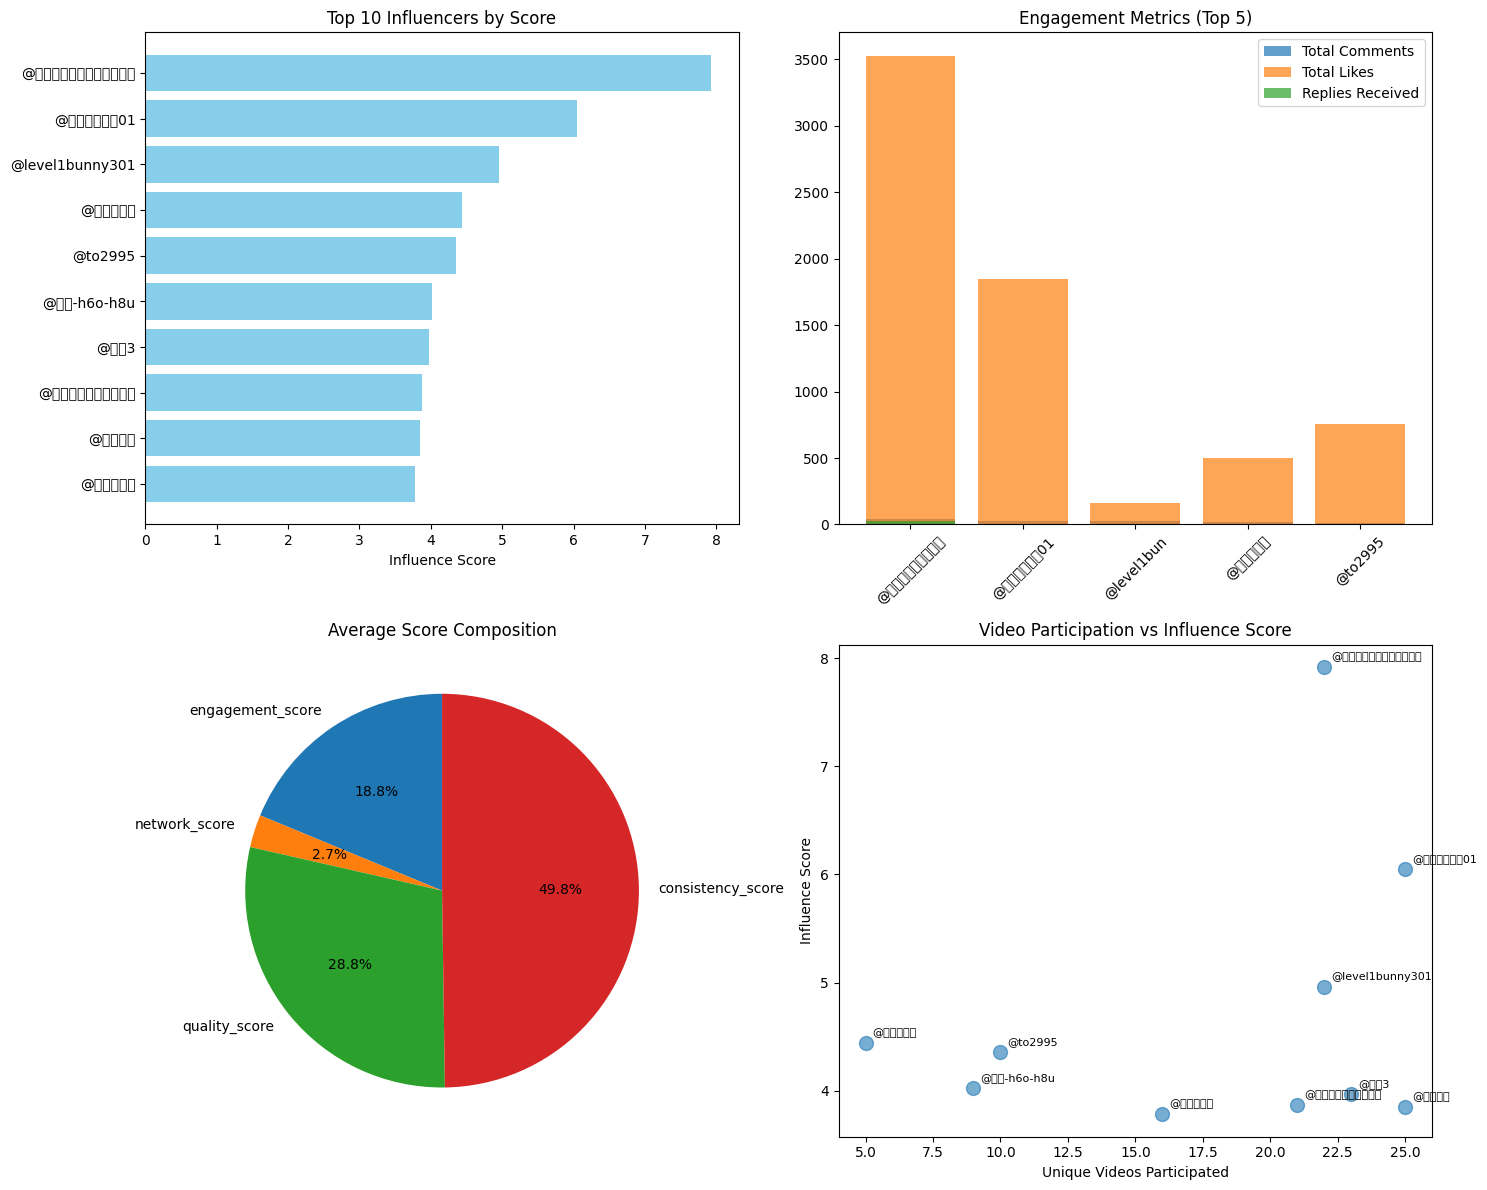


Detailed Top 5 Influencers:


,author_name,total_score,total_comments,total_likes,replies_received,unique_videos,indegree,channel_owner_replies
0,@野うさぎ印の灼熱のほむら,7.92,40,3526,25,22,23,0
1,@生きがいニキ01,6.05,25,1846,0,25,0,0
2,@level1bunny301,4.96,28,165,1,22,1,0
3,@うさぎの長,4.44,21,498,2,5,2,0
4,@to2995,4.36,10,759,0,10,0,0



Analysis complete!
Thanks for using YouTube Influencer Analysis!


In [12]:
# cell 10
# Run the analysis
if __name__ == "__main__":
    analyze_youtube_channel()

    # Option to run again
    while True:
        again = input("\n🔄 Analyze another channel? (y/n): ").lower()
        if again == 'y':
            analyze_youtube_channel()
        else:
            print("Thanks for using YouTube Influencer Analysis!")
            break